In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
alexnet = torchvision.models.alexnet(pretrained=True, progress=True)

In [2]:
alexnet.classifier[6] = nn.Linear(in_features = 4096, out_features = 4)

In [3]:
from __future__ import print_function, division

import torch

import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

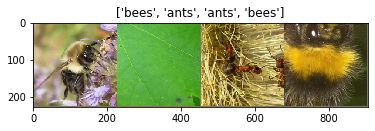

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
def train_model(model, optimizer, scheduler, num_epochs = 25):
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_correct = 0.0
            running_total = 0.0
            if phase == 'train':
                model.train()
            elif phase == 'val':
                model.eval()
            batches = iter(dataloaders[phase])
            for images, labels in batches:
                output = model(images)
                _, pred = torch.max(output, 1)
                optimizer.zero_grad()
                loss = nn.functional.cross_entropy(output, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_total += 4
                running_loss += loss
                running_correct += torch.sum(pred == labels.data)
            print("epoch: {} mode: {} avg loss: {} accuracy: {}".format(epoch, phase, 
                                                                      running_loss/running_total, 
                                                                      running_correct/running_total))
            

In [7]:
adam = optim.Adam(alexnet.classifier[6].parameters())
train_model(alexnet, adam, False)

epoch: 0 mode: train avg loss: 0.12865574657917023 accuracy: 0.811475396156311
epoch: 0 mode: val avg loss: 0.07321778684854507 accuracy: 0.8653846383094788
epoch: 1 mode: train avg loss: 0.06721331179141998 accuracy: 0.8934426307678223
epoch: 1 mode: val avg loss: 0.08469618111848831 accuracy: 0.9102563858032227
epoch: 2 mode: train avg loss: 0.04415937885642052 accuracy: 0.9303278923034668
epoch: 2 mode: val avg loss: 0.07965695858001709 accuracy: 0.9102563858032227
epoch: 3 mode: train avg loss: 0.042930252850055695 accuracy: 0.9221311211585999
epoch: 3 mode: val avg loss: 0.11398256570100784 accuracy: 0.8589743375778198
epoch: 4 mode: train avg loss: 0.0514400452375412 accuracy: 0.9098360538482666
epoch: 4 mode: val avg loss: 0.08671218156814575 accuracy: 0.9038461446762085
epoch: 5 mode: train avg loss: 0.03984544798731804 accuracy: 0.9262295365333557
epoch: 5 mode: val avg loss: 0.07574333250522614 accuracy: 0.9038461446762085
epoch: 6 mode: train avg loss: 0.0419667512178421 acc

KeyboardInterrupt: 

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

In [ ]:
batches = iter(test_loader)
num_correct = 0
num_test = 0
total_loss = 0
for image_batch, label_batch in batches:
    pred = network(image_batch)
    loss = F.cross_entropy(pred, label_batch)
    num_correct += get_num_correct(pred, label_batch)
    num_test += 100
    total_loss += loss
print("accuracy on test dataset: {}, average loss: {}".format(num_correct/num_test, total_loss/num_test) )